In [1]:
import pandas as pd
import sys
import os
from dateutil.parser import parse
from pandas.core.common import flatten
import time
import numpy as np
import json
from pprint import pprint 
from psycopg2 import connect
from more_itertools import locate
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score
import joblib
import warnings
warnings.filterwarnings("ignore")

/home/srjung/.local/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.23ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 1.13.1-unknown is an invalid version and will not be supported in a future release
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/pkg_resources/__init__.py:123: PkgResourcesDeprecationWarning: 0.1.36ubuntu1 is an invalid version and will not be supported in a future release
  warnings.warn(


## 머신러닝 학습 및 판단 개요

![nn](demo_img.png)

## 인자값 입력
### 1) 학습에 활용할 입력 데이터 필드 선택 (사용자 설정: COL NAME 입력)
### 2) 출력 필드 선택 (사용자 설정: TARGET NAME 입력)

In [2]:
#########################################
# 입력 데이터 필드
# 사용자 입력 COL_NAME as COL
col='b_soc|b_pack_current|b_pack_volt|b_moter_rpm|b_modul_1_temp|b_modul_2_temp|b_cell1_volt|b_max_chargable_power|b_inverter_capa_volt'
#########################################

col = list(col.split("|"))
ts='coll_dt'
dev_id='dev_id'

#########################################
# 출력 필드
# 사용자 입력 TARGET_NAME as TARGET
target='b_fast_charg_con_sts'
#########################################

## (사용자 설정 디렉토리 내) 학습대상 파일 리스트 자동 추출

In [3]:
#########################################
# 학습대상 파일 디렉토리 설정
path='MD_demo_training_data'
#########################################

def recursive_search_dir(_nowDir, _filelist):
    print(" [loop] recursive searching ", _nowDir, '\n')

    if os.path.isfile(_nowDir):
        _filelist.append(_nowDir)
        return None

    dir_list = []  # 현재 디렉토리의 서브디렉토리가 담길 list
    
    f_list = os.listdir(_nowDir)
    for fname in f_list:
        if os.path.isdir(_nowDir + "/" + fname):
            dir_list.append(_nowDir + "/" + fname)
        elif os.path.isfile(_nowDir + "/" + fname):
            _filelist.append(_nowDir + "/" + fname)

    for toDir in dir_list:
        recursive_search_dir(toDir, _filelist)

file_list = []
recursive_search_dir(path, file_list)

if len(file_list) == 0:      
    exit('\n\"' + _path + '\" 경로에 파일이 없습니다. 데이터셋이 있는지 확인해주세요.')
    
print(file_list)

 [loop] recursive searching  MD_demo_training_data 

['MD_demo_training_data/M1200606115.csv', 'MD_demo_training_data/M1200606106.csv', 'MD_demo_training_data/M1200606160.csv', 'MD_demo_training_data/M1200606110.csv', 'MD_demo_training_data/M1200606101.csv', 'MD_demo_training_data/M1200606102.csv', 'MD_demo_training_data/M1200606128.csv', 'MD_demo_training_data/M1200606112.csv', 'MD_demo_training_data/M1200606103.csv', 'MD_demo_training_data/M1200606104_2.csv', 'MD_demo_training_data/M1200606104_1.csv', 'MD_demo_training_data/M1200606117.csv']


## CSV 파일을 데이터프레임으로 변환

In [4]:
colm = [dev_id, ts, target]
if dev_id == '...':
    colm.remove(dev_id)

colm = col + colm

all_df = []
for file in file_list:
    f_extension = os.path.splitext(file)[1]
    if f_extension == ".csv" or f_extension == ".CSV":
        df = pd.read_csv(file, usecols=colm)
        df = df.dropna()
        df.sort_values(by=[ts],axis=0)
        all_df.append(df)
        
    '''
      # 모든 파일 데이터를 단일 데이터로 병합
    '''
one_df = pd.DataFrame()
for i in range(len(all_df)):
    one_df = pd.concat([one_df, all_df[i]], ignore_index=True)

print(one_df)

              dev_id                  coll_dt  b_soc  b_pack_current  \
0        M1200606115  2021-11-15 19:07:17.000   79.0             0.9   
1        M1200606115  2021-11-15 19:07:19.000   79.0             0.9   
2        M1200606115  2021-11-15 19:07:20.000   79.0             0.9   
3        M1200606115  2021-11-15 19:07:21.000   79.0             1.0   
4        M1200606115  2021-11-15 19:07:22.000   79.0             0.9   
...              ...                      ...    ...             ...   
2489404  M1200606117  2021-12-08 17:24:20.000   58.5             1.4   
2489405  M1200606117  2021-12-08 17:24:22.000   58.5             1.5   
2489406  M1200606117  2021-12-08 17:24:24.000   58.5             0.0   
2489407  M1200606117  2021-12-08 20:49:27.000   58.5             0.0   
2489408  M1200606117  2021-12-08 23:07:46.000   58.5             0.0   

         b_pack_volt  b_inverter_capa_volt  b_moter_rpm  \
0              387.5                 388.0          0.0   
1              38

## 머신러닝 학습 및 모델 저장

-----------------------------------------

■ XGBoost 학습 시작: 

[0]	validation_0-error:0.01334	validation_0-logloss:0.44923	validation_1-error:0.01349	validation_1-logloss:0.44925
[1]	validation_0-error:0.01295	validation_0-logloss:0.31439	validation_1-error:0.01312	validation_1-logloss:0.31457
[2]	validation_0-error:0.01280	validation_0-logloss:0.22922	validation_1-error:0.01291	validation_1-logloss:0.22918
[3]	validation_0-error:0.01263	validation_0-logloss:0.17217	validation_1-error:0.01280	validation_1-logloss:0.17209
[4]	validation_0-error:0.01169	validation_0-logloss:0.13083	validation_1-error:0.01176	validation_1-logloss:0.13075
[5]	validation_0-error:0.01183	validation_0-logloss:0.10260	validation_1-error:0.01196	validation_1-logloss:0.10249
[6]	validation_0-error:0.00971	validation_0-logloss:0.08053	validation_1-error:0.00980	validation_1-logloss:0.08040
[7]	validation_0-error:0.01138	validation_0-logloss:0.06549	validation_1-error:0.01141	validation_1-logloss:0.06540
[8]	valida


학습 소요시간: 29.77 초

-----------------------------------------

■ XGBoost 학습 평가 결과: 

오차행렬
 [[436708    123]
 [   187  60864]]
정확도: 1.00

■ XGBoost 학습 모델 저장 

./model/MD_model.pkl


['./model/MD_model.pkl']

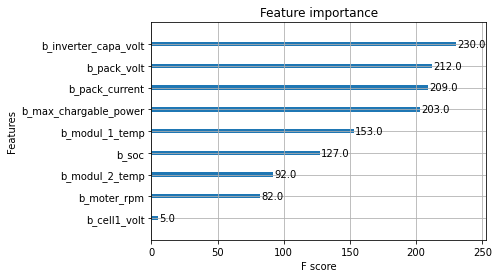

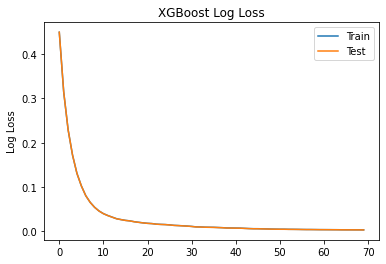

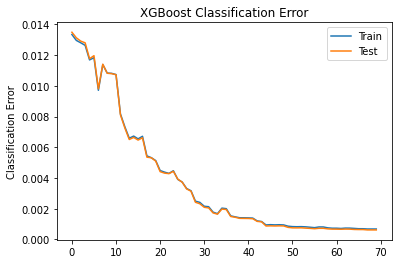

In [5]:
df = one_df

if dev_id == '...':
    X = df.drop(columns=[target, ts])
else:
    X = df.drop(columns=[target, ts, dev_id])
y = df[target]

# 학습용 평가용 데이터 분리
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
   
# XGBoost 모델 적용
print("-----------------------------------------")
print("\n■ XGBoost 학습 시작: \n")

start = time.time()

########################################################################################
# 머신러닝 학습 조건 사용자 설정 (학습 반복횟수, 결정트리 최대 깊이, 평가 메트릭 등)
xgb_clf = XGBClassifier(n_estimators=70, max_depth=5, use_label_encoder=False, eval_metric=["error", "logloss"])

########################################################################################

eval_set = [(X_train, y_train), (X_test, y_test)]
xgb_clf.fit(X_train, y_train, eval_set=eval_set, verbose=True, eval_metric=["error", "logloss"])
end = time.time()
print('\n학습 소요시간:' , round(end-start,2), '초\n')

print("-----------------------------------------")
print("\n■ XGBoost 학습 평가 결과: \n")

# 결과 도출하기
def get_clf_eval(y_test, pred, xgb_clf):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    print('오차행렬\n', confusion)
    print('정확도: {:.2f}'.format(accuracy))

    '''
       # 중요도 결과 가시화(그림 저장)
    '''
    from xgboost.plotting import plot_importance
    import matplotlib.pyplot as plt
    plot_importance(xgb_clf)
    plt.savefig('XGBoost_importance.png', bbox_inches='tight')

    '''
       # Epoch에 따른 학습 과정 가시화(그림 저장)
    '''
    from matplotlib import pyplot as plt
    results = xgb_clf.evals_result()
    epochs = len(results['validation_0']['error'])
    x_axis = range(0, epochs)
    # plot log loss
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['logloss'], label='Train')
    ax.plot(x_axis, results['validation_1']['logloss'], label='Test')
    ax.legend()
    plt.ylabel('Log Loss')
    plt.title('XGBoost Log Loss')
    plt.savefig('XGBoost_Log_Loss.png')
    # plot classification error
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['error'], label='Train')
    ax.plot(x_axis, results['validation_1']['error'], label='Test')
    ax.legend()
    plt.ylabel('Classification Error')
    plt.title('XGBoost Classification Error')

get_clf_eval(y_test, xgb_clf.predict(X_test), xgb_clf)


##################################################################
# 학습결과 모델을 pickle 파일로 저장 (디렉토리, 파일명 사용자 설정)
directory = './model/'
model_filename='MD_model'
##################################################################

try: 
    if not os.path.exists(directory): 
        os.makedirs(directory) 
except OSError: 
    print("Error: Failed to create the directory.")
print("\n■ XGBoost 학습 모델 저장 \n")
save_file = directory+model_filename+'.pkl'
print(save_file)
joblib.dump(xgb_clf, save_file)